### Workflow

1. get data ready

2. build a model ( or use a pretrained model)

3. fit the model to data

4. evaluate the model

5. improve the model

6. save and reload your model

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.1.0+cu121'

nn stands for neural network and this package contains the building blocks for creating neural networks in PyTorch

### 1.Data

In [ ]:
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Split data into training and test sets

In [ ]:
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):

  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

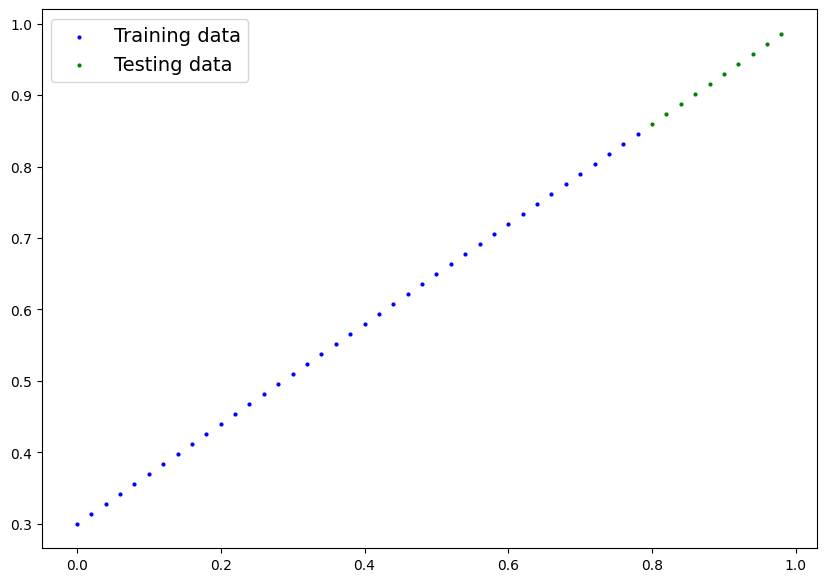

In [ ]:
plot_predictions();

### 2. Build a model

In [ ]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                                dtype=torch.float),
                                   requires_grad=True)

        self.bias = nn.Parameter(torch.randn(1,
                                            dtype=torch.float),
                                requires_grad=True)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [ ]:
#  almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
#  start with random weights (this will get adjusted as the model learns)
#  PyTorch sets float32 by default
#  start with random bias (this will get adjusted as the model learns)
#  "x" is the input data (e.g. training/testing features)
#  linear regression formula (y = m*x + b)




Almost everything in a PyTorch neural network comes from torch.nn,

1. nn.Module contains the larger building blocks (layers)
2. nn.Parameter contains the smaller parameters like weights and biases
3. forward() tells the larger blocks how to make calculations on inputs (tensors full of data) within nn.Module(s)
4. torch.optim contains optimization methods on how to improve the parameters within nn.Parameter to better represent input data


lets check the contents of a PyTorch model

In [ ]:
# lets set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(100)

# let us try to create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3607], requires_grad=True),
 Parameter containing:
 tensor([-0.2859], requires_grad=True)]

We can also get the state (what the model contains) of the model

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3607])), ('bias', tensor([-0.2859]))])

### Making predictions

In [ ]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)


torch.inference_mode() is used when using a model for inference (making predictions).

torch.inference_mode() turns off a bunch of things to make forward-passes (data going through the forward() method) faster.

In [ ]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.0026],
        [0.0098],
        [0.0170],
        [0.0242],
        [0.0315],
        [0.0387],
        [0.0459],
        [0.0531],
        [0.0603],
        [0.0675]])


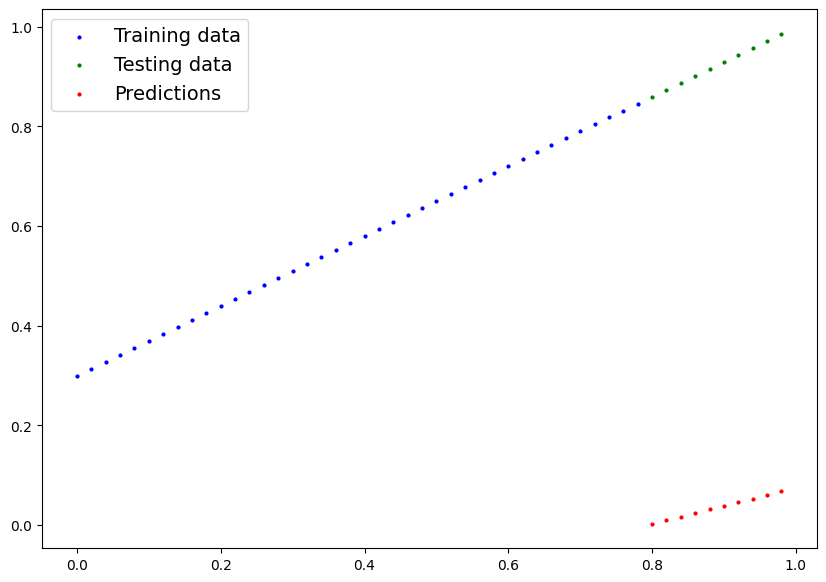

In [ ]:
plot_predictions(predictions=y_preds)

In [ ]:
y_test - y_preds

tensor([[0.8574],
        [0.8642],
        [0.8710],
        [0.8778],
        [0.8845],
        [0.8913],
        [0.8981],
        [0.9049],
        [0.9117],
        [0.9185]])

### 3. Train model

important things to note

*  Loss function

*  Optimizer

In [ ]:
# Create the loss function
loss_fn = nn.L1Loss()

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [ ]:
# "lr" is the learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))
# MAE(Mean Absolue Error ) loss is same as L1Loss
# SGD(Stochastic Gradient Descent) is a popular optimization algorithm used to minimize the loss during training.

In [ ]:
torch.manual_seed(100)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):


    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()


    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      test_loss = loss_fn(test_pred, y_test.type(torch.float))

      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.7182652950286865 | MAE Test Loss: 0.8744664192199707 
Epoch: 10 | MAE Train Loss: 0.6030553579330444 | MAE Test Loss: 0.7397564649581909 
Epoch: 20 | MAE Train Loss: 0.48784536123275757 | MAE Test Loss: 0.6050465703010559 
Epoch: 30 | MAE Train Loss: 0.37263545393943787 | MAE Test Loss: 0.4703366160392761 
Epoch: 40 | MAE Train Loss: 0.257425457239151 | MAE Test Loss: 0.3356266915798187 
Epoch: 50 | MAE Train Loss: 0.14221547544002533 | MAE Test Loss: 0.20091672241687775 
Epoch: 60 | MAE Train Loss: 0.030374601483345032 | MAE Test Loss: 0.07090263068675995 
Epoch: 70 | MAE Train Loss: 0.01594698056578636 | MAE Test Loss: 0.03711389750242233 
Epoch: 80 | MAE Train Loss: 0.01249538641422987 | MAE Test Loss: 0.028154438361525536 
Epoch: 90 | MAE Train Loss: 0.009065224789083004 | MAE Test Loss: 0.020568806678056717 


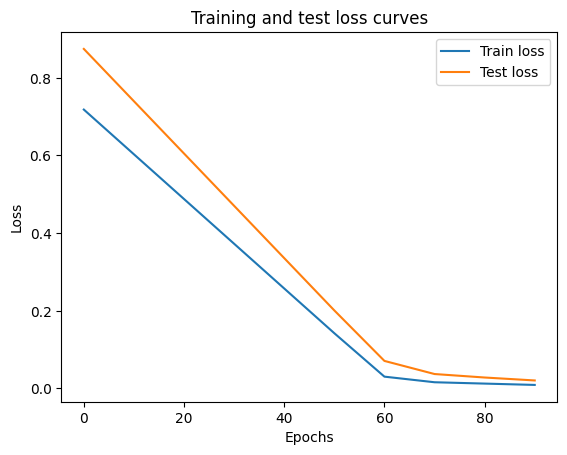

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

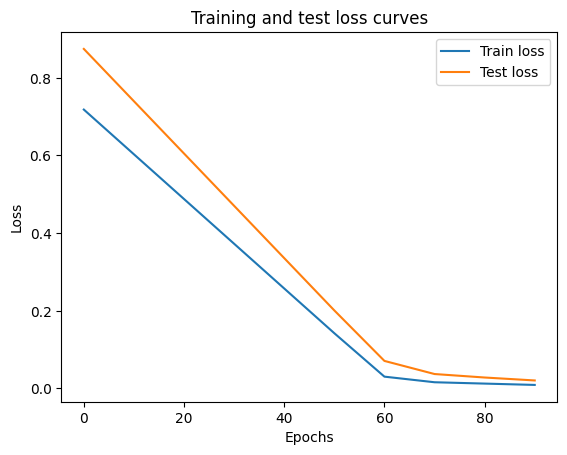

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
# Find our model's learned parameters


print("The model learned the following values for weights and bias:")
print(model_0.state_dict())


print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6719])), ('bias', tensor([0.3116]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


###  4. Making predictions with a trained PyTorch model

In [ ]:

model_0.eval()


with torch.inference_mode():
  y_preds = model_0(X_test)


y_preds

tensor([[0.8491],
        [0.8626],
        [0.8760],
        [0.8894],
        [0.9029],
        [0.9163],
        [0.9298],
        [0.9432],
        [0.9566],
        [0.9701]])

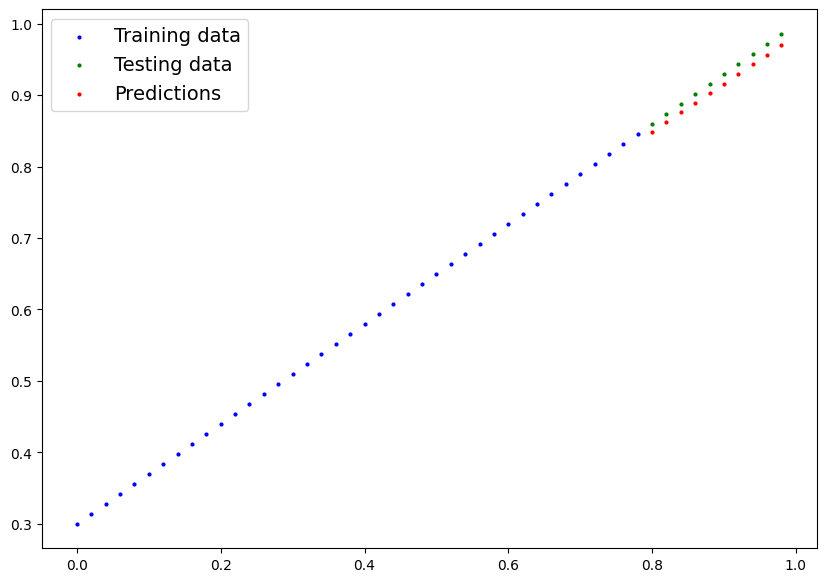

In [ ]:
plot_predictions(predictions=y_preds)

###  5. Saving and loading a PyTorch model



In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1680 Feb 12 14:59 models/01_pytorch_workflow_model_0.pth


Loading a saved PyTorch model's

In [ ]:
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>